In [14]:
import requests, re, random, json, time
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Data Gathering

In [55]:
def get_revisions(Property,rvcontinue=None):
    """
    Input:
    Property,rvcontinue
    
    Output:
    revisions, rvcontinue
    """
    URL = "https://www.wikidata.org/w/api.php"
    # defining a params dict for the parameters to be sent to the API
    PARAMS = {"action":"query",
              "prop":"revisions",
              "format":"json",
              "titles":"Property:{}".format(Property),
              "rvlimit":"500",
              "rvdir":"newer",
              "rvprop": "content|timestamp|comment",
              "rvcontinue": rvcontinue}
    
    # sending get request and saving the response as response object
    r = requests.get(url = URL,params = PARAMS)

    # extracting data in json format
    data = r.json()
    
    # Get revisions
    pages = data['query']['pages']
    keys = pages.keys()
    revisions = [pages[k]['revisions'] for k in keys]
    rvcontinue = data['continue']['rvcontinue'] if 'continue' in data else None
    
    return revisions, rvcontinue

In [56]:
def get_all_revisions(Property,rvcontinue=None):
    """
    
    output :
    
    - all_revisions
    - limit_reached 
    
    """
    
    all_revisions, continue_limit, i = [], 10, 0
        
    while True:
        revisions, rvcontinue = get_revisions(Property,rvcontinue)
        all_revisions += revisions[0]
        
        if(rvcontinue is None):
            limit_reached = False 
            break
        
        if (i > continue_limit) :
            limit_reached = True
            break
        
        i += 1

    return all_revisions, limit_reached

In [57]:
all_revisions,limit_reached = get_all_revisions('P54')

KeyboardInterrupt: 

### Data parsing

#### Method 1: using comment

|Attribute |Add| Update |Remove|
|---|---|---|---|
|label |wbsetlabel-add| wbsetlabel-set| wbsetlabel-remove|
|description |wbsetdescription-add| wbsetdescription-set| wbsetdescription-remove|
|alias |wbsetaliases-add |wbsetaliases-add-remove| wbsetaliases-remove|

wbsetlabeldescriptionaliases
wbeditentity-create

In [ ]:
tag_pattern = "(?<=\/\*)(.*)(?=\*\/)"
description_pattern = "(?<=\*\/)[^\]]+"
language_pattern = "(?<=\|)[^\]]+"

In [6]:
attributes_dict = {"wbsetlabel-":["label"],
                   "wbeditentity-create":["label"],
                   "wbsetdescription-":["description"],
                   "wbsetaliases-":["alias"],
                   "wbsetlabeldescriptionaliases":["label","description","alias"]}

actions_dict = {"-add":"add",
                "-update":"update",
                "-set":"update",
                "-add-remove":"update",
                "-remove":"remove"}

In [22]:
def parse_revisions(all_revisions):
    for revision in all_revisions.copy():

        if(not 'comment' in revision):
            all_revisions.remove(revision)
            continue
            
        comment = revision['comment']
        tag = re.findall(tag_pattern, comment)
        if(not tag):
            all_revisions.remove(revision)
            continue

        tag =tag[0]
        attributes = [v for k,v in attributes_dict.items() if k in tag]

        # If there is no attribute, we delete the element from the list
        if(not attributes):
            all_revisions.remove(revision)
            continue
        attributes = attributes[0]

        action = [v for k,v in actions_dict.items() if k in tag]
        if not action:
            if 'wbeditentity-create' in tag:
                action = ['add']
            elif 'wbsetlabeldescriptionaliases' in tag:
                action = ['uptdate']
        #description =re.findall(description_pattern, comment)[0].strip()
        language = re.findall(language_pattern,tag)[0].strip()

        revision['label'] = language if 'label' in attributes else None
        revision['description'] = language if 'description' in attributes else None
        revision['alias'] = language if 'alias' in attributes else None

        revision['action'] = action[0]
        #revision['description'] = description
        revision['language'] = language

        revision.pop('comment', None)
        revision.pop('parentid',None)
        revision.pop('user',None)
        if('anon' in revision):
            revision.pop('anon',None)
    
    return all_revisions

#### Method 2: using content

In [235]:
def parse_content(revisions):
    output,languages = [],[]
    for revision in revisions:
        
        content = revision['*']
        content = json.loads(content)
        
        if 'labels' not in content or not content['labels']:
            continue
            
        current_labels = content['labels'].keys()
        for label in current_labels:
            if label not in languages:
                languages.append(label)
                output.append({'timestamp':revision['timestamp'],
                               'property':content['id'],
                               'language':label})
                break
        
    return output

### Gather data from several properties

In [218]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setQuery("""SELECT DISTINCT ?property
    WHERE
    {
      ?property rdf:type wikibase:Property.
    }
    ORDER by ?property""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

property_name_list = []
for result in results["results"]["bindings"]:
    property_name_list.append(re.findall('([^\/]*)$',result['property']['value'])[0])

In [227]:
random.seed(1000)
property_number = 50
sample_property_name_list = random.choices(property_name_list,k=property_number - 1)
sample_property_name_list += ['P856']

In [228]:
sample_property_name_list = list(set(sample_property_name_list))

In [481]:
def get_label_creations(properties):
    """
    Get the creation time of each labels and languagues.
    Input:  - list of property name
    Output: - list of property name 
            - data/all_label_creation.csv
    
    """
    output, i, issues = [],0,[]
    total_property = len(properties)
    step = 25
    
    keys = ['timestamp', 'property', 'language']
    
    # Save the result in a file
    with open('data/all_label_creations.csv', 'w+') as output_file: # wb if python <3.x 
                dict_writer = csv.DictWriter(output_file, keys)
                dict_writer.writeheader()
    
    
    for property_name in properties:
    
        # Sleep 300ms after each batches of request
        time.sleep(0.3)
        
        try:
            all_revisions, limit_reached = get_all_revisions(property_name)
            all_revisions = parse_content(all_revisions)
        except:
            print("ERROR on {}".format(property_name))
            issues.append(property_name)
        
        if limit_reached:
            print("Limit reached on {}".format(property_name))
            issues.append(property_name)
            continue
        
        # Append the result to the CSV
        with open('data/all_label_creations.csv', 'a+') as output_file: # wb if python <3.x 
                dict_writer = csv.DictWriter(output_file, keys)
                #dict_writer.writeheader()
                dict_writer.writerows(all_revisions)
        

        # Log and save every 50 requests
        if  i%step == 0:
            now = datetime.datetime.now()        
            print("In progress:\t{0:0.2f}%\t{1}:{2}:{3}".format(100*(i/total_property),
                                                                       now.hour,
                                                                       now.minute,
                                                                       now.second))
        i+=1
    
    
    return issues 

In [484]:
issues = get_label_creations(issues[24:78])

In progress:	0.00%	16:46:22
In progress:	46.30%	16:47:8
In progress:	92.59%	16:47:56


In [470]:
issues = get_label_creations(property_name_list)

In progress:	0.00%	11:22:20
In progress:	0.48%	11:22:48
Limit reached on P373
In progress:	0.97%	11:23:34
Limit reached on P570
In progress:	1.45%	11:24:14
In progress:	1.94%	11:24:49
In progress:	2.42%	11:25:13
In progress:	2.90%	11:25:41
In progress:	3.39%	11:26:10
In progress:	3.87%	11:26:39
In progress:	4.35%	11:27:13
In progress:	4.84%	11:27:38
In progress:	5.32%	11:28:11
ERROR on P425
In progress:	5.81%	11:29:52
In progress:	6.29%	11:30:26
In progress:	6.77%	11:30:59
In progress:	7.26%	11:31:30
In progress:	7.74%	11:32:16
In progress:	8.23%	11:32:48
ERROR on P908
In progress:	8.71%	11:34:34
In progress:	9.19%	11:35:3
In progress:	9.68%	11:35:33
Limit reached on P1472
In progress:	10.16%	11:36:12
In progress:	10.64%	11:36:51
In progress:	11.13%	11:37:18
In progress:	11.61%	11:37:47
In progress:	12.10%	11:38:10
Limit reached on P244
Limit reached on P27
In progress:	12.58%	11:38:57
In progress:	13.06%	11:39:36
In progress:	13.55%	11:40:10
In progress:	14.03%	11:40:38
In progress:	1

### Save data into a CSV

In [68]:
# Clean output
for el in output:
    if 'userhidden' in el:
        el.pop('userhidden',None)
    if 'suppressed' in el:
        el.pop('suppressed',None)
    

In [67]:
import csv

keys = all_revisions[0].keys()

with open('data/all_revisions.csv', 'w+') as output_file: # wb if python <3.x 
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(output)

### Volume

In [35]:
df = pd.DataFrame.from_csv("data/all_label_creations.csv")
# Some value are dupplicated in the data set...
df.drop_duplicates(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [36]:
df.describe()

,property,language
count,110279,110276
unique,5126,234
top,P214,en
freq,129,5126


In [48]:
import numpy as np
np.arange(0.0, 1.0, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [47]:
range(0,1,1)

NameError: name 'xrange' is not defined

In [54]:
a.describe()

,language
count,5126.000000
mean,21.513071
std,20.140921
min,2.000000
25%,8.000000
50%,15.000000
75%,27.000000
max,129.000000


In [49]:
a.describe(percentiles=np.arange(0.0, 1.0, 0.1))

,language
count,5126.000000
mean,21.513071
std,20.140921
min,2.000000
0%,2.000000
10%,5.000000
20%,7.000000
30.0%,9.000000
40%,11.000000
50%,15.000000


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


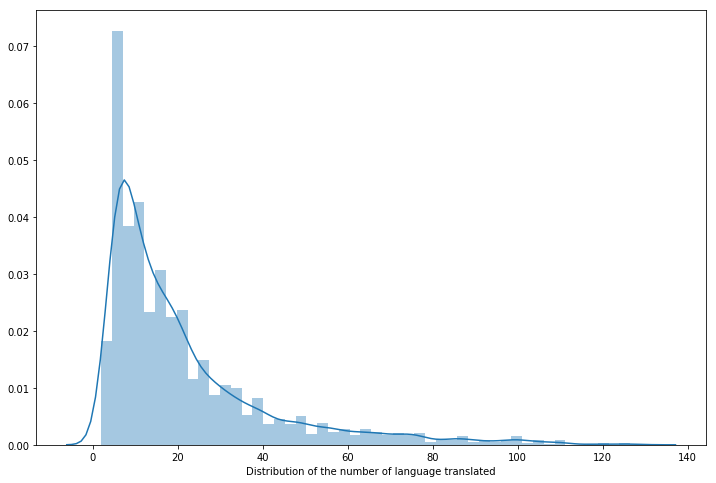

In [53]:
a = df.groupby('property').count()
# Problem with P4952 (count 880????)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 8)
sns_plot = sns.distplot(a,axlabel='Distribution of the number of language translated')
fig = sns_plot.get_figure()
fig.savefig("img/num_language_translated.png")
